# Price elasticity

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


file_path = 'metroregion_filtered_data.csv'
metropolitan_data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
metropolitan_data['Date'] = pd.to_datetime(
    metropolitan_data['Year'].astype(str) + '-' + metropolitan_data['Month'].astype(str) + '-01'
)

# Encode categorical variables
data_encoded = pd.get_dummies(
    metropolitan_data, 
    columns=['EFPG_name', 'Metroregion_name'], 
    drop_first=True
)

# Define features (X) and target (y)
X = data_encoded[['labor force', 'unemployment rate', 'Price_index_GEKS', 
                  'Unit_value_mean_wtd', 'Number_stores'] + 
                 [col for col in data_encoded.columns if 'EFPG_name_' in col or 'Metroregion_name_' in col]]
y = data_encoded['Purchase_grams_wtd']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Simulated PED Calculation Function
def calculate_ped_simulation(efpg_name, metroregion_name, date_1, date_2):
    # Filter data for the specified EFPG_name and Metroregion_name
    filtered_data = metropolitan_data[
        (metropolitan_data["EFPG_name"] == efpg_name) &
        (metropolitan_data["Metroregion_name"] == metroregion_name)
    ]
    
    # Check if both dates are present in the filtered data
    if date_1 not in filtered_data["Date"].values or date_2 not in filtered_data["Date"].values:
        print(f"One or both dates ({date_1}, {date_2}) are not available in the data for the specified inputs.")
        return None
    
    # Extract rows for the two dates
    row_11 = filtered_data[filtered_data["Date"] == date_2].iloc[0]  # Use values from date_2 (2018-11-01)
    row_12 = filtered_data[filtered_data["Date"] == date_1].iloc[0]  # Actual values from date_1 (2018-12-01)

    # Modify feature values for prediction
    modified_input = row_11.copy()
    modified_input["Unit_value_mean_wtd"] *= 1.01  # Simulate a 1% price increase
    
    # Encode categorical variables for prediction
    encoded_data = pd.get_dummies(filtered_data, columns=["EFPG_name", "Metroregion_name"], drop_first=True)
    encoded_data = encoded_data.reindex(columns=X_train.columns, fill_value=0)
    
    # Prepare input for prediction
    modified_input_encoded = encoded_data.loc[[row_11.name]].copy()
    modified_input_encoded["Unit_value_mean_wtd"] *= 1.01  # Update price feature
    
    # Predict demand for simulated input
    predicted_demand_simulated = rf_model.predict(modified_input_encoded)[0]
    actual_demand_date_2 = row_11["Purchase_grams_wtd"]
    
    # Calculate percentage changes
    price_percentage_change = 0.10 # 1% increase
    demand_percentage_change = (predicted_demand_simulated - actual_demand_date_2) / actual_demand_date_2
    
    # Compute PED
    if price_percentage_change == 0:
        print("Price percentage change is zero; PED cannot be calculated.")
        return None
    
    ped = demand_percentage_change / price_percentage_change
    
    # Return the results
    result = {
        "Modified Input (2018-12-01)": modified_input_encoded.to_dict(),
        "Actual Demand (2018-11-01)": actual_demand_date_2,
        "Predicted Demand (2018-12-01)": predicted_demand_simulated,
        "Percentage Changes": {
            "Demand Percentage Change": demand_percentage_change,
            "Price Percentage Change": price_percentage_change
        },
        "PED": ped
    }
    
    return result

# Example Usage
efpg_name_input = "Whole milk"
metroregion_name_input = "'Atlanta-Sandy Springs-Roswell  GA'"
date_1_input = pd.to_datetime("2018-12-01")
date_2_input = pd.to_datetime("2018-11-01")
ped_simulation_result = calculate_ped_simulation(efpg_name_input, metroregion_name_input, date_1_input, date_2_input)

if ped_simulation_result:
    print("\nSimulated PED Calculation Results:")
    for key, value in ped_simulation_result.items():
        print(f"{key}: {value}")


One or both dates (2018-12-01 00:00:00, 2018-11-01 00:00:00) are not available in the data for the specified inputs.


# Individual PED Simulation

## **Data Preparation**
- Filtered the dataset for a specific `EFPG_name` (product category) and `Metroregion_name` (location).
- Checked if the required dates (`date_1` and `date_2`) existed in the filtered data.

## **Feature Adjustment**
- Simulated a **1% price increase** by modifying the `Unit_value_mean_wtd` column for the specified date.

## **Prediction**
- Encoded categorical variables using **one-hot encoding** to match the training dataset structure.
- Used the **trained Random Forest Regressor** to predict the demand (`Purchase_grams_wtd`) for the modified input.

## **Percentage Changes**
- Calculated the **demand percentage change** between the predicted and actual demand for the given date.
- Used the simulated **price percentage change** (1% increase).

## **PED Calculation**
- Divided the **demand percentage change** by the **price percentage change** to compute PED.

## **Result Aggregation**
- Stored the calculated PED alongside modified input data and other relevant metrics.


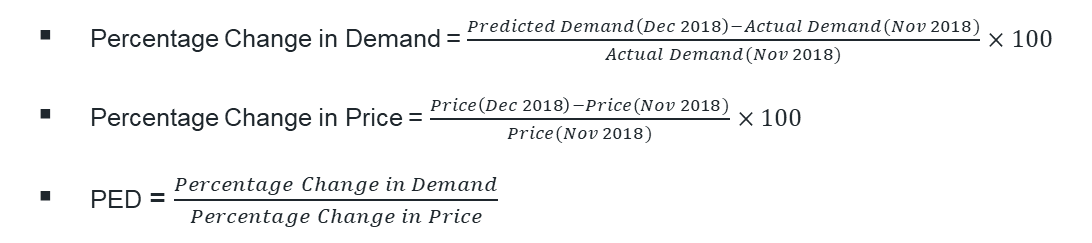

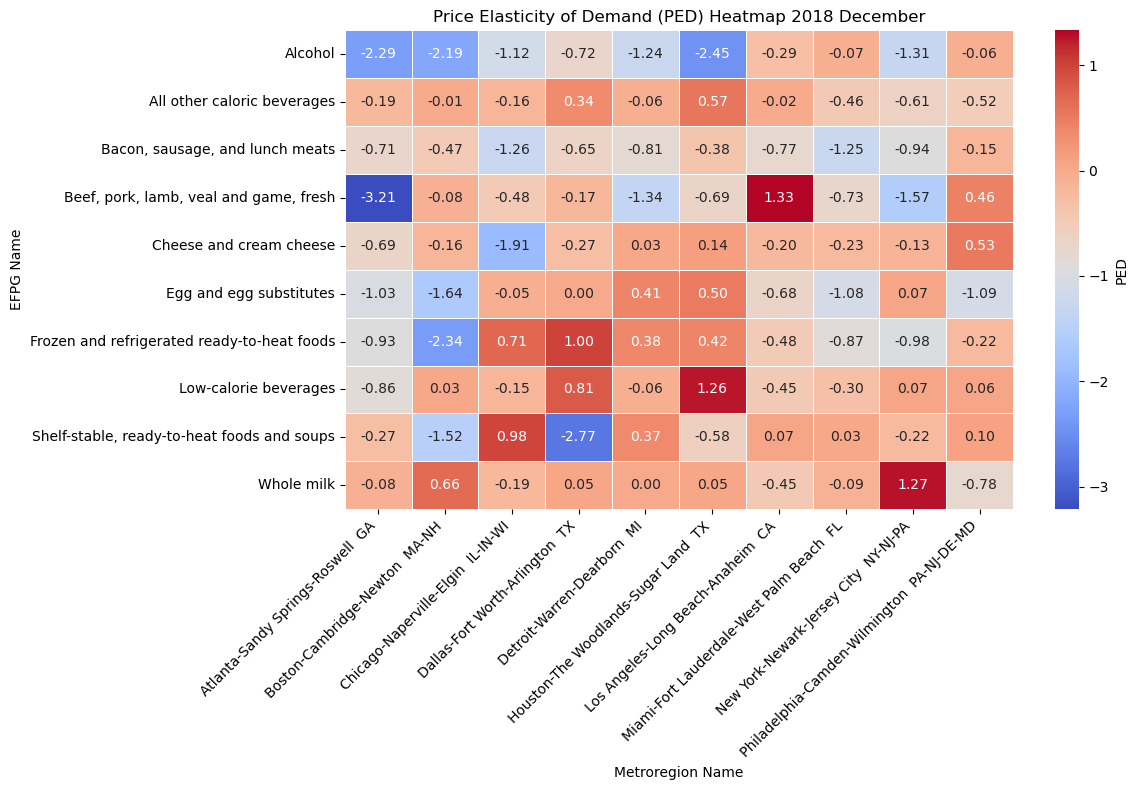

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate PED for all EFPG_name and Metroregion_name combinations
def calculate_ped_all():
    # Unique EFPG_name and Metroregion_name combinations
    efpg_names = metropolitan_data['EFPG_name'].unique()
    metroregion_names = metropolitan_data['Metroregion_name'].unique()
    
    # List to store results
    ped_results_list = []
    
    for efpg_name in efpg_names:
        for metroregion_name in metroregion_names:
            # Filter data for the specific EFPG_name, Metroregion_name, and Year 2018
            filtered_data = metropolitan_data[
                (metropolitan_data['EFPG_name'] == efpg_name) & 
                (metropolitan_data['Metroregion_name'] == metroregion_name) & 
                (metropolitan_data['Year'] == 2018)
            ]
            
            
            if filtered_data.empty:
                continue
            
            # Sort data by date
            filtered_data = filtered_data.sort_values(by='Date')
            
            # Encode categorical variables for prediction
            encoded_data = pd.get_dummies(filtered_data, columns=['EFPG_name', 'Metroregion_name'], drop_first=True)
            
            # Ensure the columns match the training dataset
            encoded_data = encoded_data.reindex(columns=X_train.columns, fill_value=0)
            
            # Predict demand
            filtered_data['Predicted_Demand'] = rf_model.predict(encoded_data)
            filtered_data['Actual_Price'] = filtered_data['Unit_value_mean_wtd']
            
            # Calculate percentage changes
            filtered_data['Price_Percentage_Change'] = filtered_data['Actual_Price'].pct_change()
            filtered_data['Demand_Percentage_Change'] = filtered_data['Predicted_Demand'].pct_change()
            
            # Compute PED
            filtered_data['PED'] = filtered_data['Demand_Percentage_Change'] / filtered_data['Price_Percentage_Change']
            
            # Drop rows with NaN or infinite PED values
            filtered_data = filtered_data.dropna(subset=['PED'])
            filtered_data = filtered_data.replace([float('inf'), -float('inf')], None).dropna(subset=['PED'])
            
            if not filtered_data.empty:
                ped = filtered_data['PED'].median()
                ped_results_list.append({
                    'EFPG_name': efpg_name,
                    'Metroregion_name': metroregion_name,
                    'PED': ped
                })
    
    # Convert the results to a DataFrame
    ped_results_df = pd.DataFrame(ped_results_list)
    return ped_results_df

# Calculate PED for all combinations
ped_results = calculate_ped_all()

# Pivot data for heatmap
heatmap_data = ped_results.pivot_table(
    index='EFPG_name',
    columns='Metroregion_name',
    values='PED',
    aggfunc='median'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'PED'}
)
plt.title("Price Elasticity of Demand (PED) Heatmap 2018 December")
plt.xlabel("Metroregion Name")
plt.ylabel("EFPG Name")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Observations from Price Elasticity of Demand (PED) Heatmap

## **1. Variability Across Categories**
- PED varies significantly across different food categories (`EFPG Name`), indicating that consumer responsiveness to price changes differs depending on the product.

## **2. Highly Elastic Products**
- Categories like **Beef, pork, lamb, veal, and game, fresh** and **Alcohol** show high negative elasticity values in certain regions, indicating that demand is highly sensitive to price changes for these products.

## **3. Positive PED Values**
- Some products, such as **Whole milk** and **Low-calorie beverages**, show positive PED values in specific metro regions.
- This may indicate a scenario where a price increase leads to an unusual demand increase, potentially due to unique regional market dynamics.

## **4. Regional Differences**
- Metro regions like **Atlanta-Sandy Springs-Roswell, GA** and **Detroit-Warren-Dearborn, MI** demonstrate more negative PED values for several categories, suggesting stronger demand sensitivity compared to other regions.

## **5. Inelastic Products**
- Categories such as **Cheese and cream cheese** and **Shelf-stable, ready-to-heat foods and soups** show relatively lower PED values, suggesting that demand for these products is less affected by price changes.

## **6. Significant Regional Elasticity**
- Some regions, such as **Houston-The Woodlands-Sugar Land, TX**, exhibit variability in PED values across categories, showing a mix of elastic and inelastic behaviors for different products.

## **7. Extreme PED Values**
- Certain combinations, such as **Beef, pork, lamb, veal, and game, fresh** in **Miami-Fort Lauderdale-West Palm Beach, FL**, show extreme PED values.
- These highlight markets where demand is unusually sensitive to price changes.

## **8. Insights for Retailers**
- Retailers can leverage this analysis to tailor pricing strategies for specific regions and categories to:
  - Maximize revenue.
  - Stabilize demand.

This heatmap provides a comprehensive view of consumer behavior across regions and product categories, offering insights into market-specific demand dynamics.
